## Предсказание будущих реакций на основе предшествующих

In [1]:
%pylab inline
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns
from IPython.display import HTML

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc('animation', html='jshtml')
# если ошибка - обновите библиотеку matplotlib

Рассмотрим некоторые приемы прогнозирования на примере времен реакции в тесте "Баланс внимания".

In [3]:
# u='http://balatte.stireac.com/result.tsv/sherdim%40gmail.com/tuts__2143043410150713'
u= 'rt.tsv'
D = pd.read_csv(u, delimiter='\t')
D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       48 non-null     float64
 1   v       45 non-null     float64
dtypes: float64(2)
memory usage: 896.0 bytes


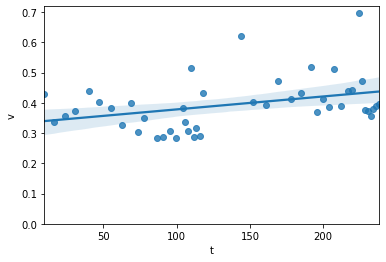

In [4]:
sns.regplot(x='t',y='v',data=D); ylim(0);

Представим, что мы хотим предсказывать время реакции (ВР) непосредственно в ходе эксперимента. Другими словами мы хотим делать прогноз в режиме "реального времени".

Для упрощения представим, что мы ничего не знаем о заданном порядке МСИ и о модальности стимула.

В нулевой момент времени у нас нет данных. Мы прогнозируем, что ВР будет как у большинства людей от 150 до 350 мс. Возмём среднее значение 0.25 с.

In [5]:
# заполним всю колонку этим значением
D['prognoz'] = 0.25
D.head()

,t,v,prognoz
0,9.585,0.429,0.25
1,16.368,0.335,0.25
2,23.729,0.357,0.25
3,30.930,0.373,0.25
4,40.303,0.439,0.25


Первые 9 секунд нашего эксперимента у нас все еще нет данных, и мы не можем оценить качество нашего прогноза. Как только появляются данные - мы можем рассчитать отклонение. Чтобы не зависеть от знака - среднеквадратичное отклонение
(root-mean-square error (RMSE)).

In [6]:
sqrt(mean((D.v[0] - D.prognoz[0])**2))

0.179

В случае одного значения это все равно что абсолютное значение разности между прогнозируемым и реальным значениями.

Если значений много, то все равно будет одно число. Это число - метрика качества нашего прогноза, на основании которой мы можем сравнивать разные алгоритмы.

Есть несколько принципов прогноза:
1. Если что-то происходит сейчас так, то и в будущем будет так же.
2. Если есть четкая тенденция, то она продолжится.
3. Текущее значение может быть артефактом, т.е. возникло в результате случайного непредвиденного воздействия, которое больше может не повториться
4. Чем больше данных в прошлом, тем лучше можно сделать прогноз будущего

Мы попробуем сделать несколько логических шагов для понимания сути однонаправленного моделирования. Более зрелые модели доступны в специальных пакетах, на которые будут ссылки в конце.

In [7]:
#сохраним текущий прогноз как первый вариант подхода "среднее по больнице"
D['pro_populatio']=D['prognoz']

#зададим функцию для удобства оценки качества прогноза
def quo(k):
    '''чем больше отклонение - тем ниже эффективность'''
    return 1/sqrt(mean((D.v - D[k])**2))
quo('pro_populatio')

5.971867109180083

Итого, если прогноз делать с потолка, то есть считать, что как у всех в среднем, то его эффективность 6 "попугаев".

Возьмем на вооружение первый принцип. Будем ждать каждый раз повторения последнего значения.

In [8]:
D.prognoz[1:]= D.v[:-1]
D.prognoz.fillna(method='ffill', inplace=True) #при пропусках оставляем предыдущий
D['pro_prev'] = D['prognoz']
quo('pro_prev')

9.590745788935852

Удивительно, но прогноз оказался хуже. Потому что постоянные 0.25 не так далеко от большинства значений в районе 0.3, а вот при прогнозе по предыдущему отдельные выбросы более 0.6 сделали свое черное дело: прогноз после них был крайне неудачным. 

In [10]:
def play_prognoz(k='prognoz', n_future = 1, k0='v', interval=500):

    xx=D.index.values
    tt= xx[:-1]

    fig = figure()
    xlim(0,len(D.index)+1); ylim(0,0.7);

    hh=[]
    hh.append( plot([],[], color='b', lw=0, marker='d')[0] )
    hh.append( plot(xx[0],D[k][0], color='r', marker='*')[0] ) #prognoz
    hh.append( vlines([],[],[], colors='pink') ) #residuals
    xlabel('Время, с');
    ylabel('Интервал между нажатиями, с');
    
    def updatefig(i):
        hh[0].set_data(xx[:i+1], D[k0][:i+1])
        hh[1].set_data(xx[[i,i+n_future]], D[k][[i,i+n_future]])
        res1=vstack([tile(xx[i],(2,)), [D.loc[i,k0],D.loc[i,k]]]).T
        hh[2].set_segments((hh[2].get_segments() + [res1]))
                            
        return hh

    close()
    ani = animation.FuncAnimation(fig, updatefig, tt, interval=interval, blit=True, repeat=False)
    return ani #HTML(ani.to_html5_video())

play_prognoz('pro_prev')

Из-за выбросов становится понятно, что полагаться только на последнее значение опрометчиво. Лучше использовать для прогноза несколько последних значений.

Для ослабления влияния выбросов в качестве оценки центральной тенденции лучше использовать медиану.

In [11]:
D['pro_median5']=D.v.rolling(5,  min_periods=1).median().shift()
play_prognoz('pro_median5')

Сравним эффективность предсказания по медиане с предсказанием по среднему.

In [12]:
D['pro_mean5']=D.v.rolling(5,  min_periods=1).mean().shift()
quo('pro_median5'), quo('pro_mean5')

(11.60262473148722, 11.4620407220412)

В данном случае среднее ведет себя лучше - 14 попугаев.

И среднее, и медиана являются способами оценить центральную тенденцию (*[M-estimator](https://en.wikipedia.org/wiki/M-estimator)*)


Вместо усреднения можно ввести взвешенное среднее, чтобы более экстремальные значения вносили меньший вклад, чем более типичные близкие к среднему. На практике используются разные [весовые функции]( http://statsmodels.sourceforge.net/stable/rlm_techn1.html).

Например, после первых 5 значений мы хотели бы иметь прогноз в районе 0.3, т.е. ослабить влияние 4-го значения, превышающего 0.4.

In [13]:
x=D.v[:5]
z=((x - x.mean())/x.std()).values
z

wRamsay = exp(-0.3*abs(z))  #Ramsay’s Ea
wRamsay = wRamsay/sum(wRamsay)

t=1.345;  wHuber = [(t/_z if _z>t else 1.) for _z in abs(z)]
wHuber = wHuber/sum(wHuber)

mean(x), sum(x*0.2), sum(x*wRamsay), sum(x*wHuber)

(0.3866, 0.3866, 0.38548646610515147, 0.3866)

Окна Рамсея и Хубера дали небольшое снижение относительно обычного среднего, в котором все слагаемые имеют одинаковый вес.

Мы берем 5 последних значений, значит средний возраст данных для прогноза - 3 временных шага. Получается, что если в серии происходят изменения - мы постоянно запаздываем в среднем на 3 шага назад.

Попробуем реализовать еще один принцип - *недавние события имеют большую предсказательную силу, чем предыдущие*. Для этого наделим большим весом последнее значение, а предыдущие - постепенно убывающими весами. 

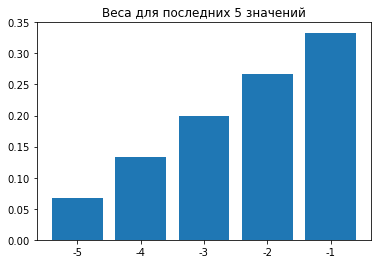

In [14]:
# weighted moving average (WMA)
w=(arange(5)+1)
w=w/w.sum()
bar(arange(5), w); xticks(arange(5), -(5-arange(5)))
title('Веса для последних 5 значений');

In [15]:
rol = D.v.fillna(method='ffill').rolling(5)

D['pro_wma']=rol.apply(lambda x: sum(x*w[-len(x):])).shift()  #shifts to future on 1 step
quo('pro_wma')

11.672902828077168

In [16]:
play_prognoz('pro_wma')

Популярное решение - *простое экспоненциальное сглаживание* (simple exponential smoothing (SES)) или exponentially weighted moving average (EWMA).

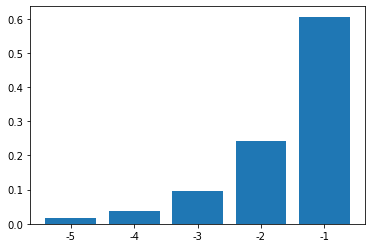

In [17]:
# exponentially weighted moving average (EWMA)
alpha = 0.6
# (1 − α)2
w=alpha*((1-alpha)**arange(5,0,-1))
w=w/w.sum()
bar(arange(5), w); xticks(arange(5), -(5-arange(5)));

In [18]:
rol = D.v.fillna(method='ffill').rolling(5)

D['pro_ewma']=rol.apply(lambda x: sum(x*w[-len(x):])).shift()
quo('pro_ewma')

11.065790559409425

In [19]:
play_prognoz('pro_ewma')

Используя экпоненциально взвешенную среднюю мы получили качество в 10 попугаев. Нам все еще мешают выбросы. Попробуем объединить веса, ослабляющие экстремальные значения, с весами, ослабляющими старые значения. Это так называемая *конволюция*.

In [20]:
def _conv1(x, alpha = 0.5):
    wEWMA=alpha*((1-alpha)**arange(5,0,-1))
    z=((x - x.mean())/x.std())
    w = exp(-0.3*abs(z))  #Ramsay’s Ea
    w=w*wEWMA
    w = w/sum(w)
    return sum(x*w)

_conv1(x)

0.40133091765005036

In [21]:
D['pro_conv1']=rol.apply(_conv1).shift()
quo('pro_conv1')

11.718295717620574

In [22]:
def _conv2(x, alpha = 0.5, t=1.345):
    wEWMA=alpha*((1-alpha)**arange(5,0,-1))
    z=((x - x.mean())/x.std())
    w = [(t/_z if _z>t else 1.) for _z in abs(z)]
    w=w*wEWMA
    w = w/sum(w)
    return sum(x*w)

_conv2(x)

0.40435483870967737

In [23]:
D['pro_conv2']=rol.apply(_conv2).shift()
quo('pro_conv2')

11.548905370184283

In [24]:
play_prognoz('pro_conv2')

Если мы уверены, что величина выброса не имеет значения, то можем загнать данные в заданные рамки. Это позволит более адекватно оценивать модели. Просто удалить выбросы при моделировании динамики нежелательно, поскольку мы нарушим ход времени. Замена на пустые значения также снизит информативность.

Например, в данном случае что 0.4, что 0.65 с характеризуют поздние реакции при пропуске стимула. Мы можем задать границу 0.4, чтобы все поздние реакции отклонялись в большую сторону, но при этом не так влияли на среднее значение. Такой прием, автоматически загоняющий выбросы в пределы заданных перцентилей, называется *винсоризацией*.

In [25]:
import scipy.stats.mstats

D['vwin']=scipy.stats.mstats.winsorize(D.v, 0.1)
D.vwin.describe()

count    48.000000
mean      0.407812
std       0.094593
min       0.290000
25%       0.346250
50%       0.390000
75%       0.439000
max       0.622000
Name: vwin, dtype: float64

In [26]:
D['prowin_conv2']=D.vwin.fillna(method='ffill').rolling(5).apply(_conv2).shift()
def quowin(k):
    return 1/sqrt(mean((D.vwin - D[k])**2))
quo('prowin_conv2')

11.155523984888513

In [27]:
play_prognoz('prowin_conv2', k0='vwin')

Можно попробовать еще более продвинутые методы расчета весовых коэффициентов для подбора лучшего предсказания по группе последних значений, например [IRLS](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares) с [функцией потерь Хубера](https://en.wikipedia.org/wiki/Huber_loss) или разные варианты ARIMA.

Кроме линейной можно попробовать сплайновую интерполяцию - `scipy.interpolate.spline`

### +++:

[Embedding Matplotlib Animations in Jupyter Notebooks](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/)

[Moving average and exponential smoothing models](https://people.duke.edu/~rnau/411avg.htm)